In [1]:
import numpy as np
import osmnx as ox
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle
import pymde
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve, lsqr
from scipy.linalg import solve_triangular, qr
import scipy
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding

import mlrfit as mf
import lrrouting as ldr
import time

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 10


mtype = "pacifica"
place = "Pacifica, CA, USA"
G, Adj, Dist, nodes_cc = ldr.dist_matrix_osmnx(place, directed=True, nodes=True)

A = Dist
m = n = A.shape[0]
diam_G = A.max()
w_min = A[A>0].min()
print(m, diam_G, w_min, (Adj>0).sum())

[903, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
n_cc = 903, n0 = 931
in  degrees: {0: 0, 1: 266, 2: 92, 3: 477, 4: 66, 5: 2}
out degrees: {0: 0, 1: 262, 2: 102, 3: 469, 4: 68, 5: 2}
903 67.0 1.0 2155


In [4]:
# G_cc = G.subgraph(nodes_cc)
# assert nx.is_strongly_connected(G_cc)
np.histogram(Dist.flatten(), bins=5, density=True)

(array([0.01418792, 0.0256659 , 0.02506663, 0.00881034, 0.00089608]),
 array([ 0. , 13.4, 26.8, 40.2, 53.6, 67. ]))

In [5]:
adjacency_list = ldr.adjacency_directed_list(Adj)

In [6]:
filename = "%s_r%d_%d"%(mtype, rank, n)

# Sample rows and columns of distance matrix

In [7]:
nsamples = 0.1 * n
rand_frac = 0.975
print(f"{rand_frac=}")
pi_rows, pi_cols = ldr.adaptive_row_col(n, Dist, frac=rand_frac, coeff=nsamples, percent=True)
rDist, cDist, pi_rows_c, pi_cols_c = ldr.sample_dist(n, pi_rows, pi_cols, Dist)

rand_frac=0.975
nsamples=815, random_samples=794


# Low dimensional embeddings

In [8]:
storage = 0.4
rank = int(np.ceil(n * storage / 100))

Z = ldr.low_dim_embeddings(n, rank, pi_rows, pi_cols, rDist, cDist)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/parshakova.tanya/Documents/projects/lr_distributed_routing/lrrouting/cg.py:48: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  rho0 = np.dot(r, z)
/Users/parshakova.tanya/Documents/projects/lr_distributed_routing/lrrouting/cg.py:72: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  losses[k] = np.sqrt(np.dot(r, r)) / b_norm


losses[0]=22.37, losses[-1]=0.00, len(losses)=232


# DAR

In [9]:
lr_dar = ldr.construct_xy_node_embedding_graph(Z[:n], Z[n:], adjacency_list)

# Find route from $s$ to $t$

In [12]:
s = 200; t = 600
route_lr, w_lr = lr_dar.route(s, t)

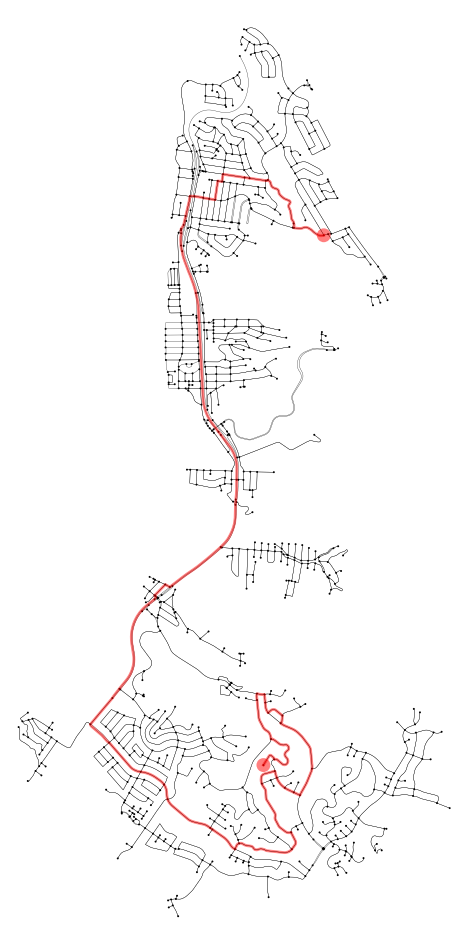

In [13]:
node_ids = list(G.nodes())
routes = [ldr.map_to_node_ids(route_lr, node_ids, nodes_cc)]
rc = ['c', 'y', 'r']

fig, ax = ox.plot_graph_route(G, routes[-1], route_color='r', bgcolor="#ffffff", \
                                edge_color='k', edge_linewidth=0.2, node_color='k', route_linewidth=2, node_size=2, figsize=(12, 12))

# fig.savefig(f"plots/{mtype}_r{rank}.pdf", bbox_inches='tight')
plt.show()